### IMPLEMENTING MULTI-HEAD ATTENTION WITH WEIGHT SPLITS

<div class="alert alert-block alert-info">
<b>Multi-head Attention with Weights Splits</b> 
<p>   

The Idea here is , as shown in below diagram.
We create multiple heads (Causal attentions) with each heads having its own Weight Matrices . 

Calculate the QUERY, KEY, VALUE and the concat them. This is computational not efficient . This is show in 1<sup>st</sup> part of the diagram


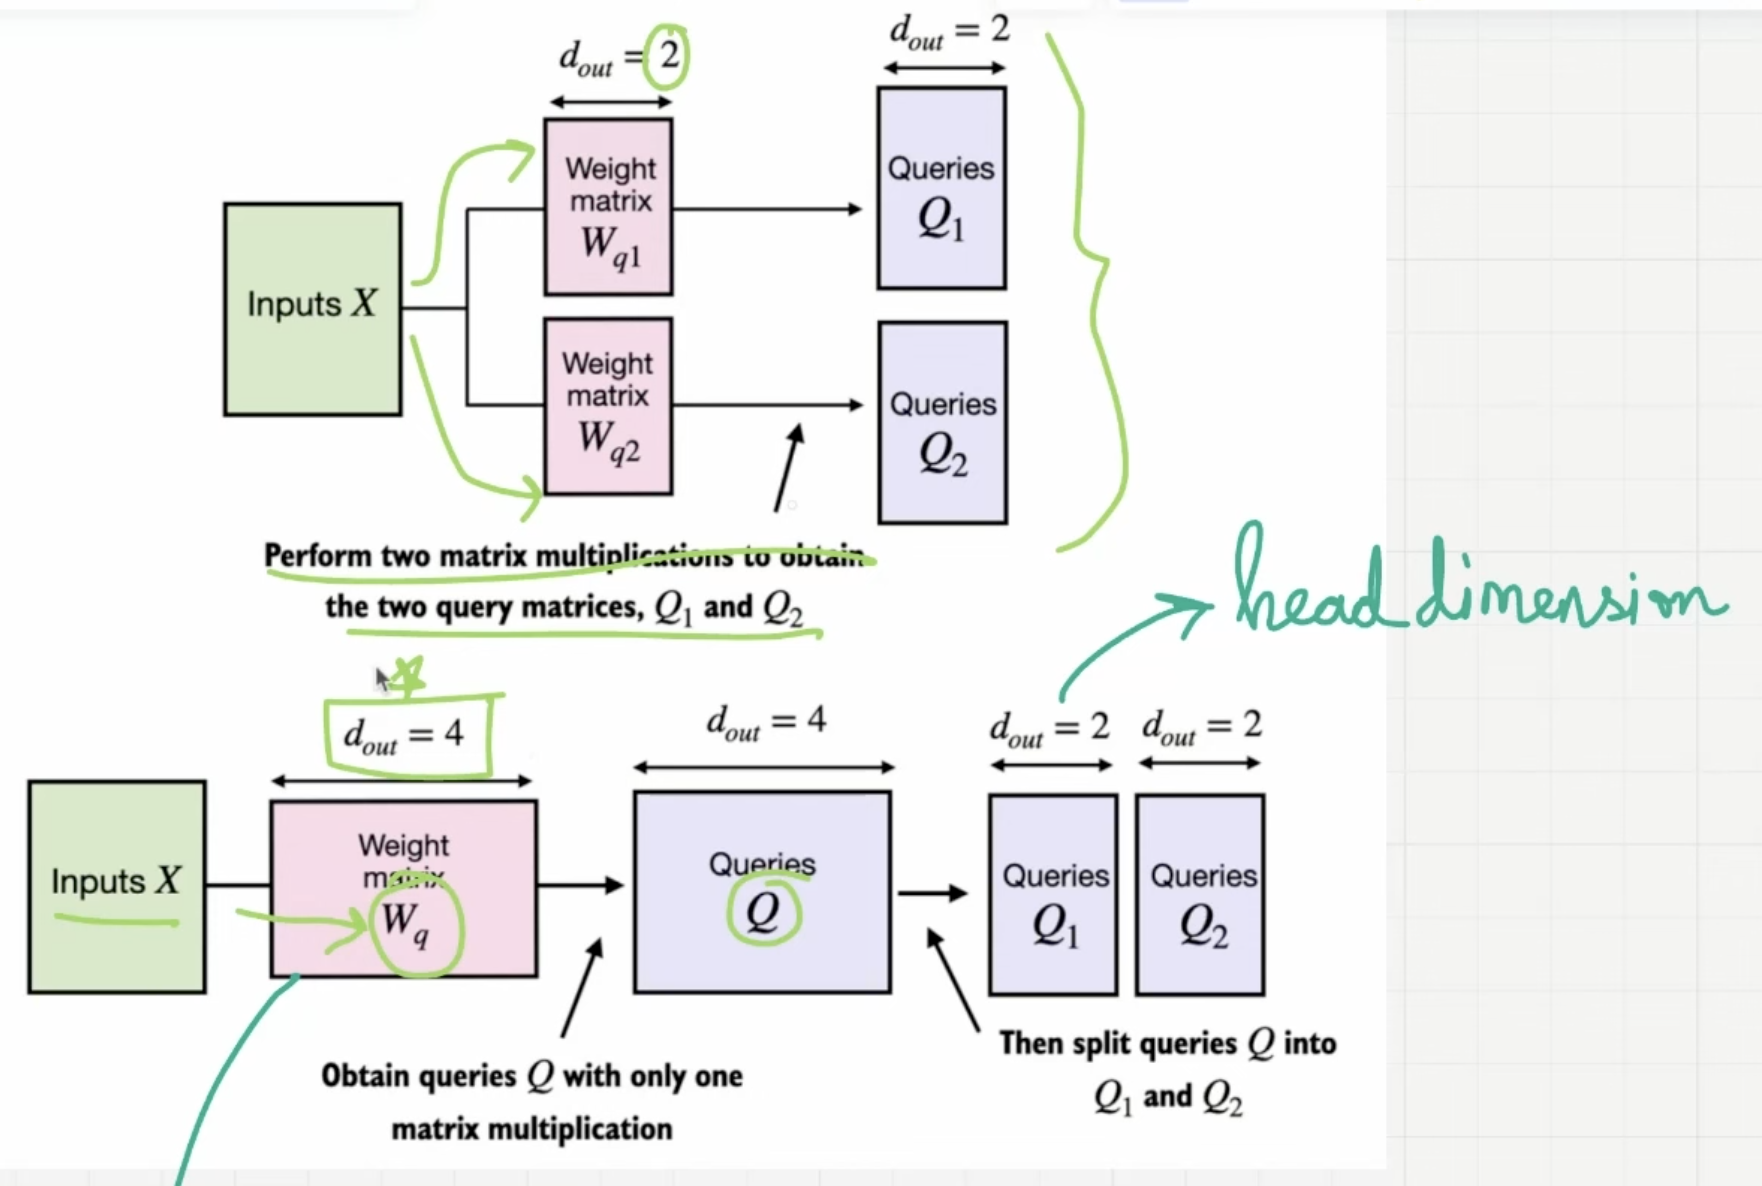

Instead of doing this, what if we create the Weight Matrices for QUERY,KEY and VALUE large enough (equal to num_heads * head_dimensions).

Perform the operations anf then split if out in its required QUERY,KEY, VALUE matrices (or reshape the vector) . This will be computationally very efficient.
This is show in the 2<sup>nd</sup> part of diagram

</p>
</div>



<div class="alert alert-block alert-info">
<b>Few of the new attributes</b> 
<p>    

head_dimension = 
d_out :- Dimension of Weight Matrices QUERY,KEY,VALUE across columns
num_heads = This is the number of the heads (Casual Attentions) we want to calcuate

Formula :

<span>
    head_dimension = d_out / num_heads
</span>

</p>
</div>



### How to do it

<div class="alert alert-block alert-warning">
    
Instead of maintaining two separate classes, MultiHeadAttentionWrapper and
CausalAttention, we can combine both of these concepts into a single
MultiHeadAttention class. 

Also, in addition to just merging the
MultiHeadAttentionWrapper with the CausalAttention code, we will make some other
modifications to implement multi-head attention more efficiently.
</div>

<div class="alert alert-block alert-warning">
    
In the MultiHeadAttentionWrapper, multiple heads are implemented by creating a list
of CausalAttention objects (self.heads), each representing a separate attention head.


The CausalAttention class independently performs the attention mechanism, and the
results from each head are concatenated.

In contrast, the following MultiHeadAttention
class integrates the multi-head functionality within a single class. 


It splits the input into
multiple heads by reshaping the projected query, key, and value tensors and then combines
the results from these heads after computing attention.
</div>

In [9]:
import torch
import torch.nn as nn
import numpy as np

In [97]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out ,context_length , dropout , num_heads , qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads ==0) , f"d_out should be divisible by num_heads"

        self.d_out= d_out
        self.num_heads = num_heads
        self.head_dim= d_out // num_heads # check above for the explaination
        
        # Here we have initialixed the Weight Matrices with larger dimensions already
        # This if to perform operations and then split to its respect heads based on value num_head
        # So in this example we decide d_out = 6 , hence with num_heads =2 , we will have 2 heads (causal attentions) with 3 dimension each
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        
        self.dropout= nn.Dropout(dropout)
        self.register_buffer("mask" ,
                             torch.triu(torch.ones(context_length , context_length),
                             diagonal=1))

    def forward(self,x):
        b,num_tokens,d_in = x.shape

        print("Dimension of Weight Matrice before inputs operation" , self.W_value.weight.shape , "\n")
        # this gives us the 3 * 6 Weight matrices
        queries = self.W_key(x)
        keys    = self.W_query(x)
        values  = self.W_value(x)
        print("Dimension of Weight Matrice after inputs operation:" , values.shape , "\n")
        print("Values of Weight Matrice after inputs operation: \n" , values , "\n")

        # We implicitly split the matrix by adding a `num_heads` dimension
        # reshape the last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        # basically we just reshaping it per token , per head  (group by tokens)
        keys = keys.reshape(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.reshape(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.reshape(b, num_tokens, self.num_heads, self.head_dim)
        
        print("Dimension of Weight Matrice after Reshape operation:" , values.shape, "\n") 
        print("Values of Weight Matrice after Reshapr operation: \n" , values, "\n")

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        # This is required becuase we want to perform multiplication operation between data (token and dimesnion)
        # so we get the data that is tokens  and embedding at rthe end
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        print("Dimension of Weight Matrice after Grouping by Head operation:" , values.shape, "\n") 
        print("Values of Weight Matrice after Grouping by Head  operation: \n" , values, "\n")

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # Now attn score dimension is (batch , head_num , tokens , head_dim)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        print("Dimension of Attention cores Matrice :" , attn_scores.shape, "\n") 
        print("Values of Attention cores Matrice: \n" , attn_scores, "\n")

        
        # Original mask truncated to the number of tokens and converted to boolean
        # this is tghe edge case , if there are token less then context length (end of datasets)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        print("Values of Masked Boolean Matrix: \n" , mask_bool, "\n")

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        print("Values of Masked Attention cores Matrice: \n" , attn_scores, "\n")

        # Perform the normalization
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        # Perform the droput
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        #context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

<div class="alert alert-block alert-warning">
<b>Let look at  the dimensions of key Matrices</b> 

<p>

Input = 3 * 6 (3 tokens and 6 embedding dimensions)

batch = 2 * 3 * 6 (We have 2 batches of input = 3 * 6)

context_length = 3 (meaning we have 3 tokens to analyse before predeciting nex word)

d_in = 6 (6 embedding dimensions of input)

d_out =6 (This is the dimension of embedding of Weight matrices QUERY , KEY and VALUE)

Weight Matrices (Q,K,V) = 6 * 6

</p>
</div>

<div class="alert alert-block alert-info">
<b> Steps to perform multi-head attention</b>

Step 1: Reduce the projection dim to match desired output dim

Step 2: Use a Linear layer to combine head outputs

Step 3: Tensor shape: (b, num_tokens, d_out)

Step 4: We implicitly split the matrix by adding a `num_heads` dimension. Then we unroll last dim: (b,
num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)

Step 5: Transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)

Step 6: Compute dot product for each head

Step 7: Mask truncated to the number of tokens

Step 8: Use the mask to fill attention scores

Step 9: Tensor shape: (b, num_tokens, n_heads, head_dim)

Step 10: Combine heads, where self.d_out = self.num_heads * self.head_dim

Step 11: Add an optional linear projection
</div>

In [98]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
# 
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Token 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Token 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Token 3
)

In [101]:
batch = torch.stack((inputs, inputs), dim=0)
print("Size of the Batch:" , batch.shape, "\n") 

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)
print("Dimension of the context_vecs.shape:", context_vecs.shape , "\n")
print("Values of the context vector", context_vecs , "\n")


Size of the Batch: torch.Size([2, 3, 6]) 

Dimension of Weight Matrice before inputs operation torch.Size([6, 6]) 

Dimension of Weight Matrice after inputs operation: torch.Size([2, 3, 6]) 

Values of Weight Matrice after inputs operation: 
 tensor([[[ 0.0734,  0.3735, -0.4600, -0.1481, -0.3729, -0.0084],
         [ 0.3167,  0.1246, -0.2096, -0.0539, -0.1522,  0.1382],
         [ 0.4033, -0.0576, -0.2063,  0.1262, -0.1398,  0.0401]],

        [[ 0.0734,  0.3735, -0.4600, -0.1481, -0.3729, -0.0084],
         [ 0.3167,  0.1246, -0.2096, -0.0539, -0.1522,  0.1382],
         [ 0.4033, -0.0576, -0.2063,  0.1262, -0.1398,  0.0401]]],
       grad_fn=<UnsafeViewBackward0>) 

Dimension of Weight Matrice after Reshape operation: torch.Size([2, 3, 2, 3]) 

Values of Weight Matrice after Reshapr operation: 
 tensor([[[[ 0.0734,  0.3735, -0.4600],
          [-0.1481, -0.3729, -0.0084]],

         [[ 0.3167,  0.1246, -0.2096],
          [-0.0539, -0.1522,  0.1382]],

         [[ 0.4033, -0.0576, -0

In [96]:
batch.shape

torch.Size([2, 3, 6])